## Nonparametric Regression with K-Nearest Neighbors


In [2]:
import numpy as np
import pandas as pd
from plotnine import *

Let's start with a simulated function to estimate nonparametrically:

In [4]:
# Define the true regression function
def g(x):
    return np.maximum(x, 5) + 0.5 * x * np.sin(x)

# Generate the data
np.random.seed(1234)  # For reproducibility
x = np.arange(0, 10, 0.01)
x_sample = np.sort(np.random.choice(x, 100, replace=False))
y = g(x_sample) + np.random.normal(0, 0.5, size=100)

# Create dataframes to hold simulated data
data = pd.DataFrame({'x': x_sample, 'y': y})
data_nonoise = pd.DataFrame({'x': x_sample, 'g': g(x_sample)})


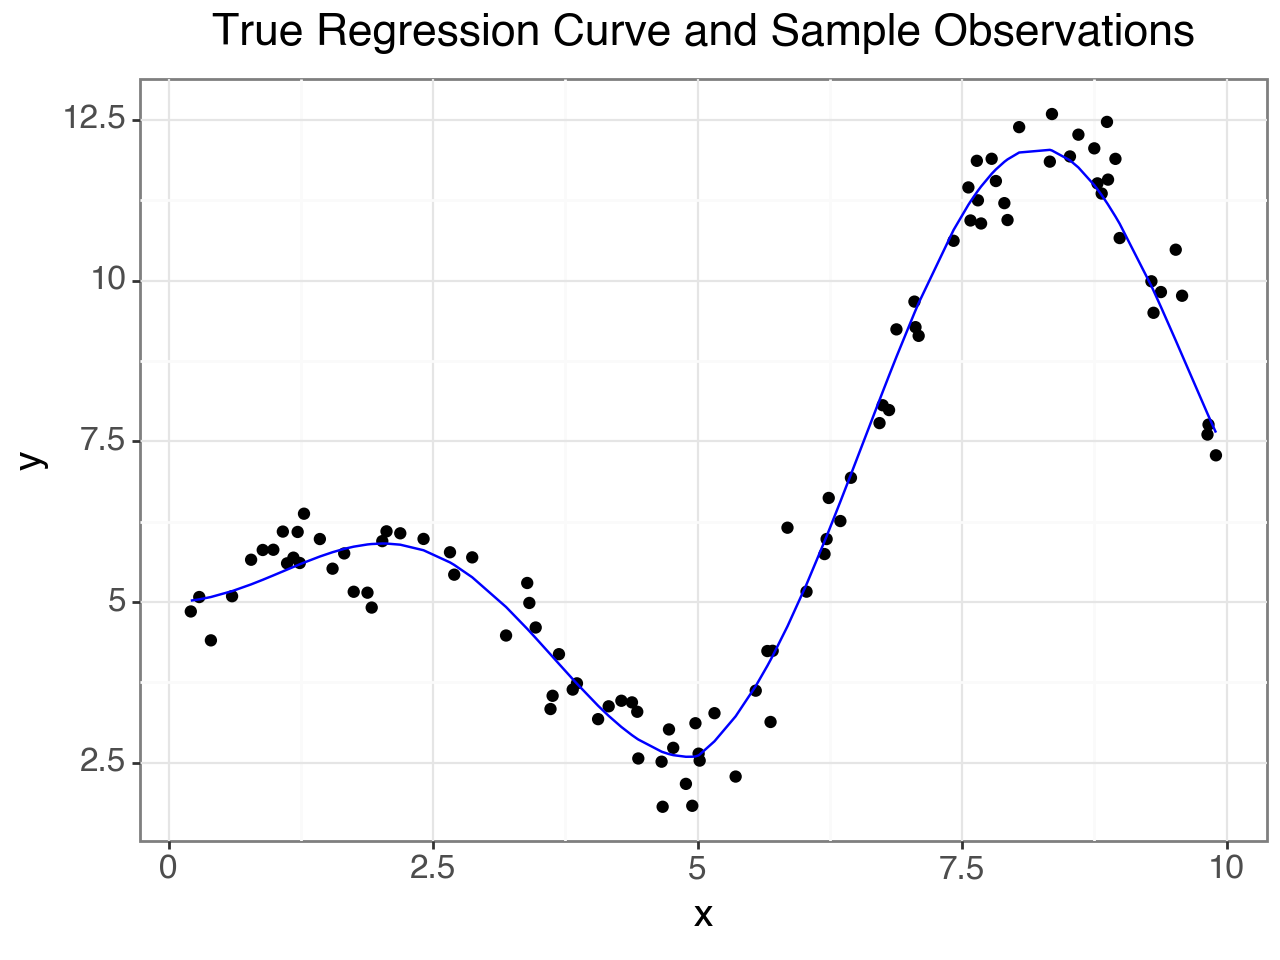

<Figure Size: (640 x 480)>

In [5]:
plot1 = (
    ggplot() +
    geom_point(data, aes(x='x', y='y'), color='black') +
    geom_line(data_nonoise, aes(x='x', y='g'), color='blue') +
    theme_bw() +
    labs(title='True Regression Curve and Sample Observations', y='y') +
    theme(
        plot_title=element_text(ha='center', size=16),
        axis_title=element_text(size=14),
        axis_text=element_text(size=12)
    )
)

plot1

### Let's try to implement KNN regression from scratch:

For example, let's try to predict y when x = 2, using K=10 nearest neighbors...

Our first step will be to find the 10 nearest neighbors near x=2!

In [8]:
# Pick the x point of interest
x_point = 2

# Calculate distances from observations to x_point & sort them
dist = np.abs(data['x'] - x_point)
sorted_dist = dist.sort_values()

# We want the K smallest distances
K = 10
k_indices = sorted_dist.index[:K]
k_dists = sorted_dist.iloc[:K]

# Find out which points these correspond to
neighbor_x = data.loc[k_indices, 'x']
print("Neighbor x-values:", neighbor_x.values)

Neighbor x-values: [2.02 2.06 1.92 1.88 2.19 1.75 1.66 2.41 1.55 1.43]


Let's wrap this into a function which takes x and K as arguments so we can use it repeatedly and build onto it:

In [10]:
def neighbors(x_point, K, xvar, data):
    # Calculate distances & sort them
    dist = np.abs(data[xvar] - x_point)
    sorted_dist = dist.sort_values()
    k_dists = sorted_dist[:K]
    
    # Find out which points these correspond to
    neighbor_ind = np.where(np.isin(dist, k_dists))[0]
    
    # Break ties by randomly subsetting down to K
    if len(neighbor_ind) != K:
        neighbor_ind = np.random.choice(neighbor_ind, K, replace=False)
    
    neighbor_x = data.iloc[neighbor_ind][xvar]
    
    # Return the indices and x-values for the K nearest neighbors
    out = {'ind': neighbor_ind, 'xvals': neighbor_x.values}
    return out

Before moving on, apply it to the situation before to sanity check that it works...:

In [12]:
neighbors(x_point = 2, K = 10, xvar = 'x', data = data)

{'ind': array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
 'xvals': array([1.43, 1.55, 1.66, 1.75, 1.88, 1.92, 2.02, 2.06, 2.19, 2.41])}

Ok cool, now let's use these neighbors to predict the y value!

In [14]:
nearby_points_idx = neighbors(x_point = 2, K = 10, xvar = 'x', data = data)['ind']
y_hat_knn = data.iloc[nearby_points_idx]['y'].mean()
y_hat_knn

5.656884670423805

In [15]:
def knn_predict(x_point, K, xvar, yvar, data):
    nearby_points_idx = neighbors(x_point, K, xvar, data)['ind']
    knn_pred = data.iloc[nearby_points_idx][yvar].mean()
    return knn_pred

# Example prediction at x = 2
prediction = knn_predict(2, K=10, xvar='x', yvar='y', data=data)
print(f"KNN Prediction at x=2: {prediction}")

KNN Prediction at x=2: 5.656884670423805


Predicting over a grid of x-values...

In [17]:
# make a grid of x-values
x_grid = np.arange(0, 10, 0.1)
predictions = [knn_predict(x_point, K=10, xvar='x', yvar='y', data=data) for x_point in x_grid]

pred_df = pd.DataFrame({'x': x_grid, 'y': predictions})
pred_df.head()

,x,y
0,0.0,5.409209
1,0.1,5.409209
2,0.2,5.409209
3,0.3,5.409209
4,0.4,5.409209


And plotting, where red is the estimate and blue is the true function:

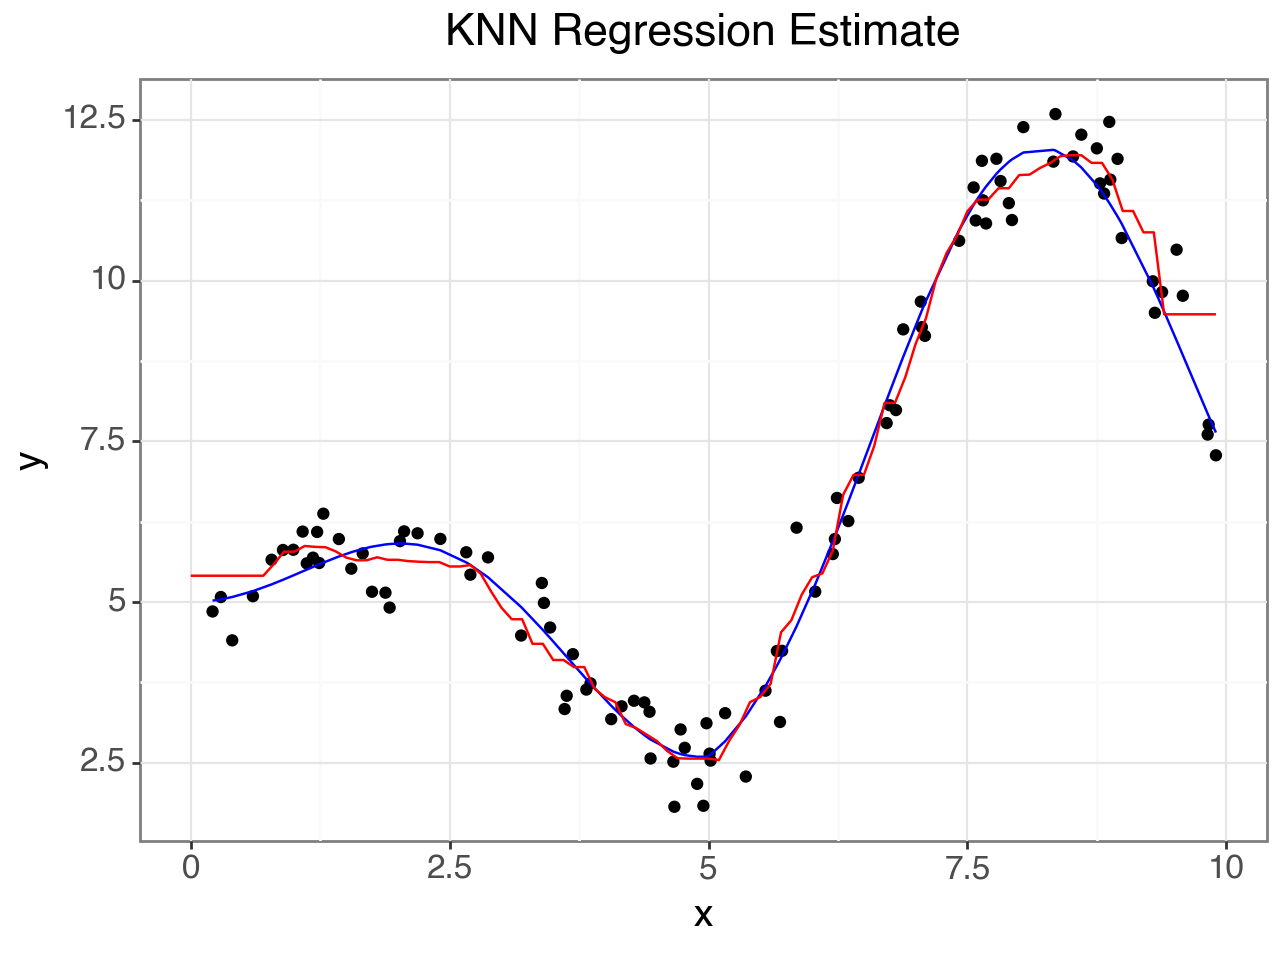

<Figure Size: (640 x 480)>

In [19]:
# Plot the data, true function, and KNN estimate
plot2 = (
    ggplot() +
    geom_point(data, aes(x='x', y='y'), color='black') +
    geom_line(data_nonoise, aes(x='x', y='g'), color='blue') +
    geom_line(pred_df, aes(x='x', y='y'), color='red') +
    theme_bw() +
    labs(title='KNN Regression Estimate', y='y') +
    theme(
        plot_title=element_text(ha='center', size=16),
        axis_title=element_text(size=14),
        axis_text=element_text(size=12)
    )
)
plot2


If we want to assess goodness of fit we can calculate the SSE:

In [21]:
# Calculate fitted values and SSE
fitted_values = [knn_predict(xi, K=10, xvar='x', yvar='y', data=data) for xi in data['x']]
sse = np.sum((data['y'] - fitted_values) ** 2)
print(f"SSE for K=10: {sse}")

SSE for K=10: 34.190330283485366


In [22]:
# Define the SSE function
def SSE(K, data):
    fitted_values = [knn_predict(xi, K=K, xvar='x', yvar='y', data=data) for xi in data['x']]
    sse = np.sum((data['y'] - fitted_values) ** 2)
    return sse

# Example SSE 
sse_value = SSE(K=10, data=data)
print(f"SSE for K=10: {sse_value}")

SSE for K=10: 34.218171317054306


We expect these values to be the same... why is the SSE changing slightly each time we run it? 

## How to choose the best value of K? 

We could perform data splitting and choose the value of K which minimizes the validation data set mean square error. Or we could do k-fold cross validation if we want to let each data point have a turn in the validation set.

## K-fold Cross-Validation Idea:

###  - For a grid of K values, $\verb|K|$ in $\verb|K_grid|$:

#### - For each observation i = 1,...,n:
1. Exclude the $i$th observation one at a time. This ith observation will serve as the "validation set."
2. Fit the K-Nearest Neighbor regression on the remaining $n-1$ observations (the training set).
3. Predict the $y$ value for the $i$th data point.
4. Calculate squared prediction error and store it as $SSE_{(i)}$.

#### After you've done this for each i = 1,...,n, average the squared prediction errors. This is the cross-validated $MSE_{CV}(K) = \frac{1}{n}\sum_{i=1}^n SSE_{(i)}$. 

### Choose the value of $\verb|K|$ in $\verb|K_grid|$ which minimizes $MSE_{CV}(K)$ 


Exercise:
1. Write a function which performs leave-one-out cross-validation.
2. Apply it to our dataset in this simulation. What is the optimal value of $K$? Call it $K^*$.
3. Calculate the SSE of the cross-validated KNN regression model with $K=K^*$. Compare it to the SSE for our initial choice of K=10. Does the tuning make a big difference in this case or were we close to correct with our initial hyperparameter choice?